In [36]:
# Hand Activity Recognition Using Multi-Sensor WISDM Dataset  

# This notebook uses the **full UCI WISDM dataset**, including:

# - Watch accelerometer (3 axes)
# - Watch gyroscope (3 axes)
# - Phone accelerometer (3 axes)
# - Phone gyroscope (3 axes)

# We focus on **12 hand-oriented activities**:

# - Dribbling  
# - Playing catch  
# - Typing  
# - Writing  
# - Clapping  
# - Brushing teeth  
# - Folding clothes  
# - Eating pasta  
# - Eating soup  
# - Eating sandwich  
# - Eating chips  
# - Drinking (glass)



In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True

In [38]:
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"]
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# WATCH SENSORS
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")

# PHONE SENSORS
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

# MERGE – use OUTER so we don’t lose rows
df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

print(df_all.shape)
print(df_all["activity"].unique()[:20])  # first few activity codes


(9854871, 15)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']


## Task 2 — Extract Hand-Oriented Activities

We keep 12 activities related to hand motion:

- Dribbling  
- Playing catch  
- Typing  
- Writing  
- Clapping  
- Brushing teeth  
- Folding clothes  
- Eating pasta  
- Eating soup  
- Eating sandwich  
- Eating chips  
- Drinking 


In [39]:
# 12 hand-related activity codes from WISDM-51 dataset
hand_activities = [
    "P",  # dribbling
    "O",  # playing catch
    "F",  # typing
    "Q",  # writing
    "R",  # clapping
    "G",  # brushing teeth
    "S",  # folding clothes
    "J",  # eating pasta
    "H",  # eating soup
    "L",  # eating sandwich
    "I",  # eating chips
    "K"   # drinking
]


# ensure activity column is clean
df_all["activity"] = df_all["activity"].astype(str).str.strip()

# Filter hand activities
df_hand = df_all[df_all["activity"].isin(hand_activities)].copy()
df_hand = df_hand.reset_index(drop=True)

df_hand["activity"].value_counts()



activity
P    572389
K    571651
O    566768
H    548889
S    548165
R    547468
G    545602
I    543510
L    535868
Q    531434
F    517955
J    509715
Name: count, dtype: int64

In [40]:
activity_code2name = {
    "A": "Walking",
    "B": "Jogging",
    "C": "Stairs",
    "D": "Sitting",
    "E": "Standing",
    "F": "Typing",
    "G": "Brushing teeth",
    "H": "Eating soup",
    "I": "Eating chips",
    "J": "Eating pasta",
    "K": "Drinking",
    "L": "Eating sandwich",
    "M": "Kicking (soccer ball)",
    "O": "Playing catch",
    "P": "Dribbling",
    "Q": "Writing",
    "R": "Clapping",
    "S": "Folding clothes",
}

# reverse mapping: from readable name → code
activity_name2code = {v: k for k, v in activity_code2name.items()}


In [41]:
import numpy as np
import matplotlib.pyplot as plt

FS = 20
WIN_S = 10
WIN_N = FS * WIN_S

def plot_middle_window(df_src, user_id, activity_code):
    # 1) select data for that user + activity
    seg = df_src[(df_src["user"] == user_id) &
                 (df_src["activity"] == activity_code)].copy()
    seg = seg.sort_values("timestamp").reset_index(drop=True)

    n = len(seg)
    if n < WIN_N:
        print("Not enough samples:", n)
        return

    # 2) find middle 10-second window (200 samples)
    start = n // 2 - WIN_N // 2
    end   = start + WIN_N
    window = seg.iloc[start:end]

    # 3) create time axis in seconds (0 → 10)
    t = np.arange(len(window)) / FS

    # 4) plot
    plt.figure(figsize=(8,4))
    plt.plot(t, window["w_acc_x"], label="x-axis", color="orange")
    plt.plot(t, window["w_acc_y"], label="y-axis", color="tab:blue")
    plt.plot(t, window["w_acc_z"], label="z-axis", color="green")
    title_map = activity_code2name
    plt.title(title_map[activity_code])
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()




Activity G (Brushing teeth), user 1639


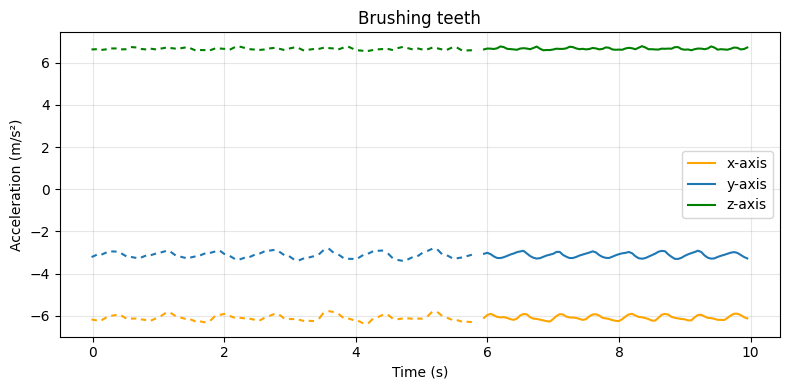

No user with >= 200 samples for activity D
Activity I (Eating chips), user 1639


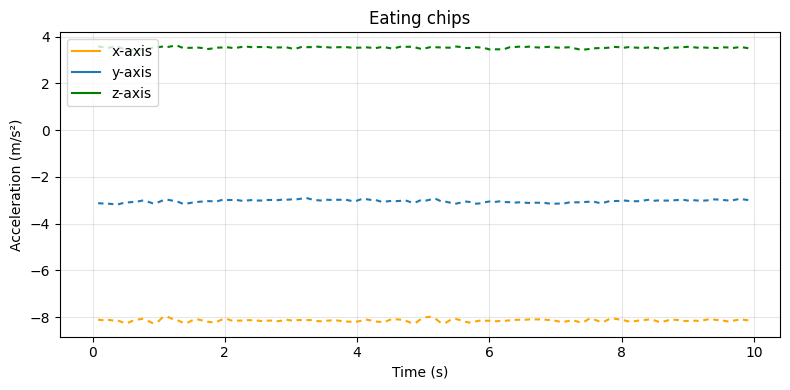

No user with >= 200 samples for activity W
Activity Q (Writing), user 1603


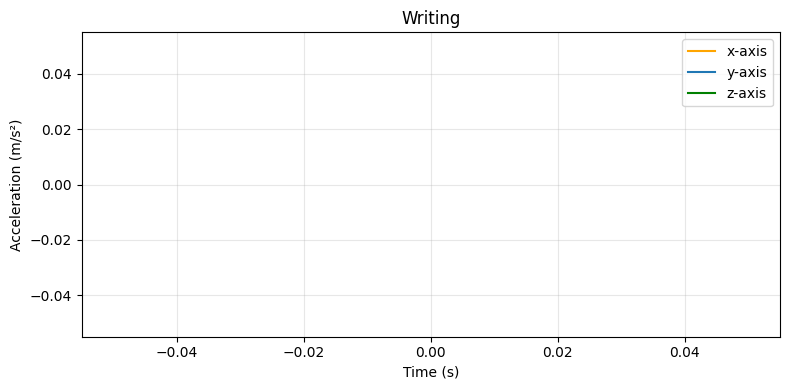

Activity F (Typing), user 1630


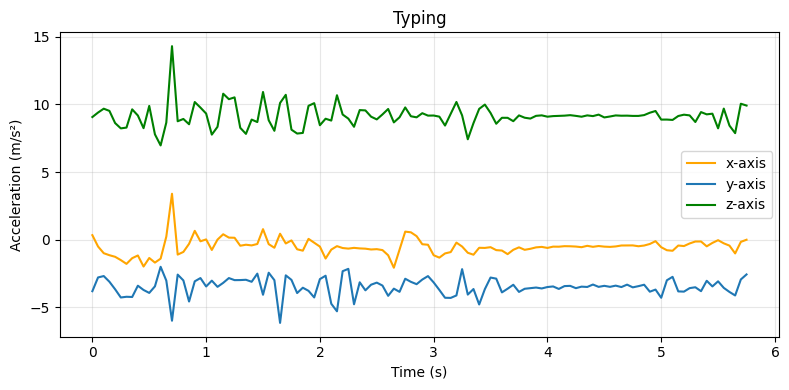

In [42]:
def pick_valid_users(df_src, activity_code):
    users = df_src[df_src["activity"] == activity_code]["user"].unique()
    valid = []
    for u in users:
        n = len(df_src[(df_src["user"] == u) &
                       (df_src["activity"] == activity_code)])
        if n >= WIN_N:
            valid.append(u)
    return valid


# --- G, D, I, W, Q, F ---
for code in ["G", "D", "I", "W", "Q", "F" ]:
    valid_users = pick_valid_users(df_hand, code)
    if not valid_users:
        print(f"No user with >= {WIN_N} samples for activity {code}")
        continue

    rand_user = np.random.choice(valid_users)
    print(f"Activity {code} ({activity_code2name[code]}), user {rand_user}")

    plot_middle_window(df_hand, rand_user, code)

## Task 3 — Preprocessing

We apply:

1. **Interpolation** for missing samples  
2. **Butterworth low-pass filter** (4th order, 5 Hz) to remove noise  

We filter all **12 sensor channels**.


In [43]:
# Sampling rate (WISDM watch/phone sensors)
FS = 20  # Hz

def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    """
    Apply a Butterworth low-pass filter to a 1D signal.

    Parameters
    ----------
    x : array-like
        Input time series.
    cutoff : float
        Cutoff frequency in Hz.
    fs : float
        Sampling rate in Hz.
    order : int
        Filter order.

    Returns
    -------
    y : np.ndarray
        Filtered signal.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)


In [44]:
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]
df_raw = df_hand.copy()

# Interpolate missing values and apply low-pass filter
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear")
    df_hand[col] = butter_lowpass_filter(df_hand[col].values)


Rows with this activity: 545602


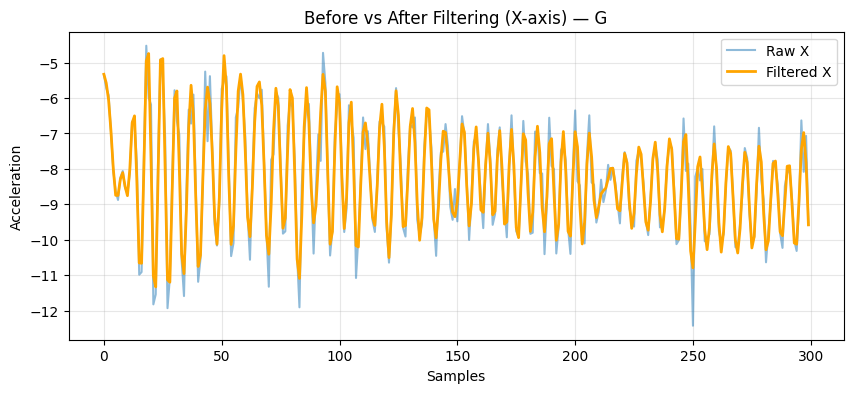

In [45]:
# --- choose one noisy activity ---
example_code = "G"
mask = df_hand["activity"] == example_code
print("Rows with this activity:", mask.sum())

if mask.sum() == 0:
    print("can not find activity", example_code)
    print("Activity:", df_hand["activity"].unique())
else:
    example_user = df_hand.loc[df_hand["activity"] == example_code, "user"].iloc[0]

    # Filtered dataframe
    df_f = df_hand[(df_hand["user"] == example_user) &
                   (df_hand["activity"] == example_code)].copy()

    # Raw dataframe
    df_r = df_raw[(df_raw["user"] == example_user) &
                  (df_raw["activity"] == example_code)].copy()

    # Select channel (first 300 samples)
    raw_x      = df_r["w_acc_x"].values[:300]
    filtered_x = butter_lowpass_filter(raw_x, cutoff=5, fs=FS)

    act_name = activity_code2name.get(example_code, example_code)

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(raw_x, label="Raw X", alpha=0.5)
    plt.plot(filtered_x, label="Filtered X", color="orange", linewidth=2)
    plt.title(f"Before vs After Filtering (X-axis) — {example_code}")
    plt.xlabel("Samples")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## Task 4 — Sliding-Window Segmentation

We adopt a sliding-window strategy, which is standard in human activity recognition.
Accelerometer and gyroscope streams do not contain explicit event boundaries, so fixed-length
windows provide a consistent temporal structure for feature extraction and classification.

We evaluate several window lengths from **20 to 200 samples**:

- 20, 40, 60, 80, 100, 120, 140, 160, 180, 200 samples

If the sampling rate were 50 Hz, these would correspond to windows from 0.4 s to 4 s.
In our dataset (20 Hz), the same sizes span 1 s to 10 s. Smaller windows are more sensitive
to rapid transitions, whereas larger windows capture more stable, aggregated motion patterns.

We also use **50% overlap** to increase the number of training segments while preserving
temporal continuity. These windowed segments are then passed to the feature extraction
and modeling stages.


In [46]:
def create_windows(df, window_size=200, overlap=0.5):
    """
    Segment a multivariate time series into overlapping windows.

    Parameters
    ----------
    df : DataFrame
        Must contain sensor_cols + 'activity'.
    window_size : int
        Number of samples per window.
    overlap : float
        Fractional overlap between consecutive windows (0–1).

    Returns
    -------
    X : np.ndarray
        Array of shape (num_windows, window_size, num_channels).
    y : np.ndarray
        Activity label for each window (majority label inside window).
    """
    step = int(window_size * (1.0 - overlap))
    X, y = [], []

    signals = df[sensor_cols].values
    acts = df["activity"].values

    for start in range(0, len(df) - window_size, step):
        end = start + window_size
        window = signals[start:end]
        # majority label inside the window
        label = pd.Series(acts[start:end]).mode()[0]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


# quick check of how many windows each size would generate
WINDOW_SIZES = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

for ws in WINDOW_SIZES:
    X_tmp, y_tmp = create_windows(df_hand, window_size=ws, overlap=0.5)
    print(f"Window size {ws:3d} → {X_tmp.shape[0]} windows")

# For the remaining experiments we use the largest window (200 samples).
windows, labels = create_windows(df_hand, window_size=200, overlap=0.5)
windows.shape, labels.shape


Window size  20 → 653940 windows
Window size  40 → 326969 windows
Window size  60 → 217979 windows
Window size  80 → 163484 windows
Window size 100 → 130787 windows
Window size 120 → 108989 windows
Window size 140 → 93419 windows
Window size 160 → 81741 windows
Window size 180 → 72659 windows
Window size 200 → 65393 windows


((65393, 200, 12), (65393,))

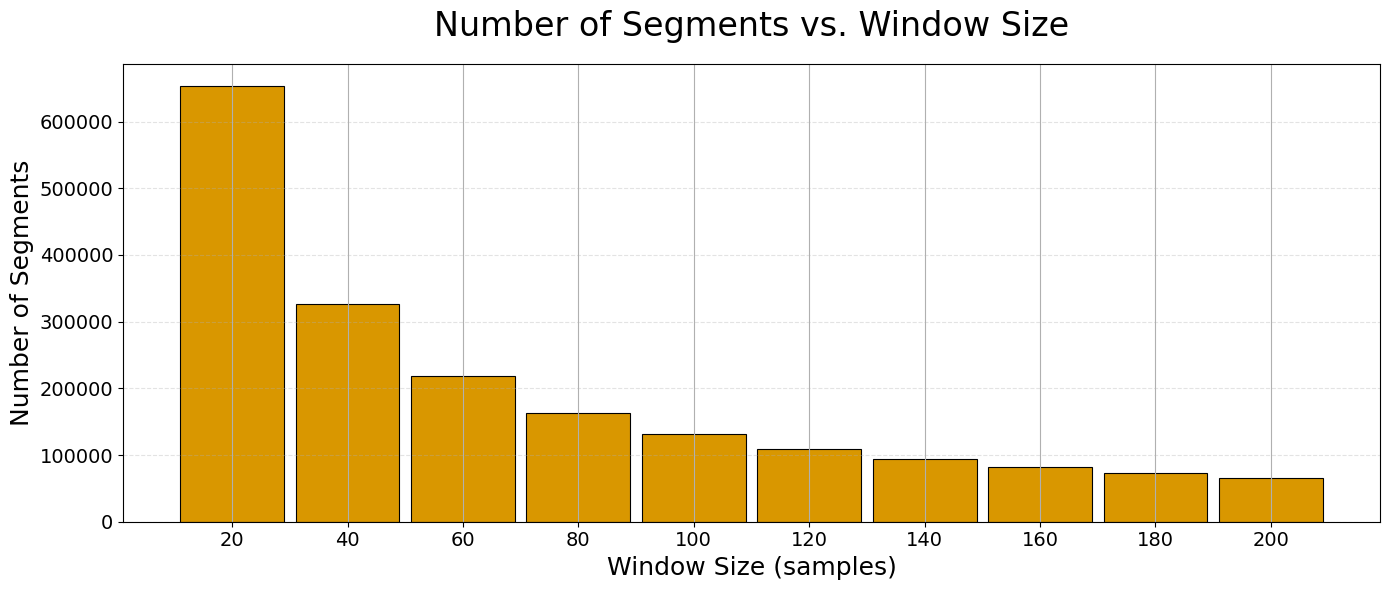

In [47]:
import matplotlib.pyplot as plt

WINDOW_SIZES = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

segment_counts = []

for ws in WINDOW_SIZES:
    X_tmp, y_tmp = create_windows(df_hand, window_size=ws, overlap=0.5)
    segment_counts.append(len(X_tmp))

plt.figure(figsize=(14,6))

plt.bar(WINDOW_SIZES, segment_counts,
        color="#D99700", edgecolor="black", linewidth=0.8, width=18 )

plt.title("Number of Segments vs. Window Size", fontsize=24, pad=20)
plt.xlabel("Window Size (samples)", fontsize=18)
plt.ylabel("Number of Segments", fontsize=18)

plt.xticks(WINDOW_SIZES, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()



## Task 5 — Time- and Frequency-Domain Feature Extraction

For each window, we transform the raw 12-channel signal into a compact feature vector.

For **every sensor channel**, we compute:

**Time-domain features (4):**
- Mean
- Standard deviation
- Root mean square (RMS)
- Zero-crossing rate (ZCR)

**Frequency-domain features (3):**
- Dominant frequency (peak in the power spectrum)
- Spectral energy
- Spectral entropy

This yields **7 features per channel**. With 12 channels, each window is represented by  
**84 features** (12 × 7), which are used as input to a Random Forest classifier.


In [48]:
def time_features_1d(x):
    mean = np.mean(x)
    sd   = np.std(x)
    rms  = np.sqrt(np.mean(x**2))

    # Zero-crossing rate
    signs = np.sign(x)
    signs[signs == 0] = 1
    zcr = np.sum(signs[1:] != signs[:-1]) / len(x)

    return [mean, sd, rms, zcr]


def freq_features_1d(x, fs=FS):
    N = len(x)
    yf = rfft(x)
    xf = rfftfreq(N, 1.0 / fs)

    power = np.abs(yf) ** 2

    # dominant frequency (exclude DC if desired)
    idx = np.argmax(power[1:]) + 1
    dom_freq = xf[idx]

    energy = np.sum(power)

    p = power / (energy + 1e-12)
    entropy = -np.sum(p * np.log(p + 1e-12))

    return [dom_freq, energy, entropy]


In [49]:
def extract_features_window(window):
    """
    Extract 7 features for each channel in a single window.
    window shape: (window_size, num_channels)
    """
    feats = []
    for c in range(window.shape[1]):  # 12 channels
        x = window[:, c]
        feats.extend(time_features_1d(x))
        feats.extend(freq_features_1d(x))
    return np.array(feats)

# Build feature matrix X and label vector y
X = np.array([extract_features_window(w) for w in windows])
y = labels

X.shape, len(y)


((65393, 84), 65393)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [51]:
# --- Build feature name list (12 channels × 7 features = 84) ---
feature_names = []

for ch in sensor_cols:
    for f in ["mean", "std", "rms", "zcr", "domfreq", "spec_energy", "spec_entropy"]:
        feature_names.append(f"{ch}_{f}")

len(feature_names)


84

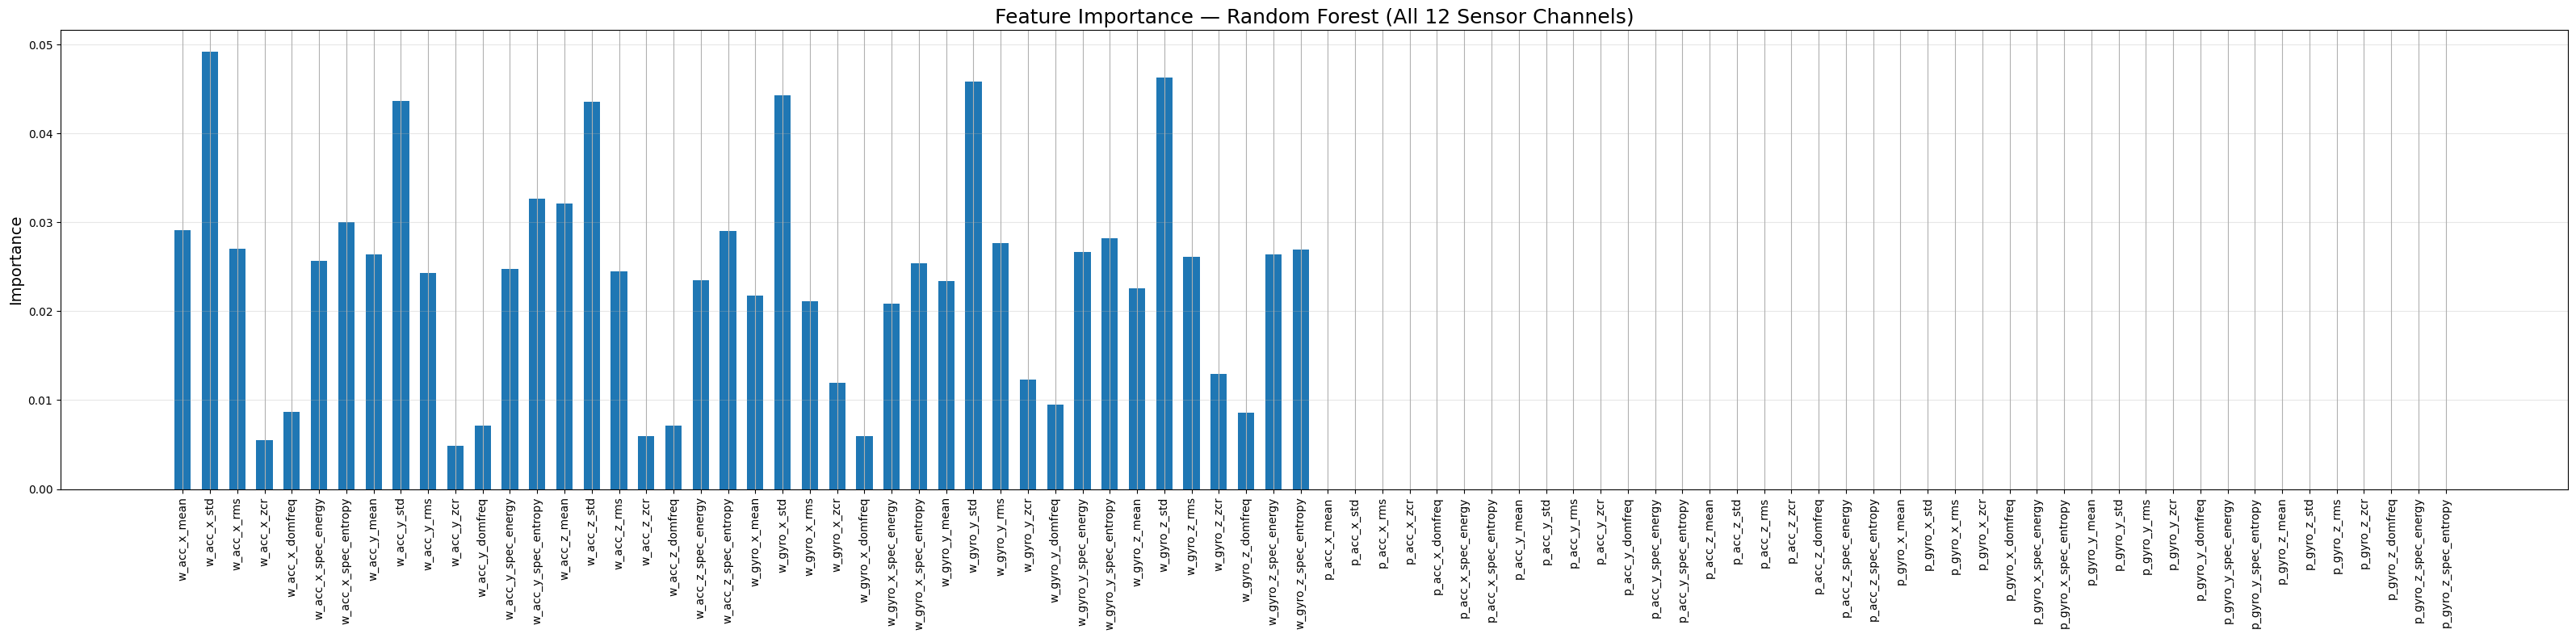

In [52]:
importances = rf.feature_importances_

plt.figure(figsize=(32, 8))  
plt.bar(range(len(importances)), importances, width=0.6)

plt.xticks(
    range(len(importances)),
    feature_names,
    rotation=90,
    fontsize=10
)

plt.title("Feature Importance — Random Forest (All 12 Sensor Channels)", fontsize=18)
plt.ylabel("Importance", fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



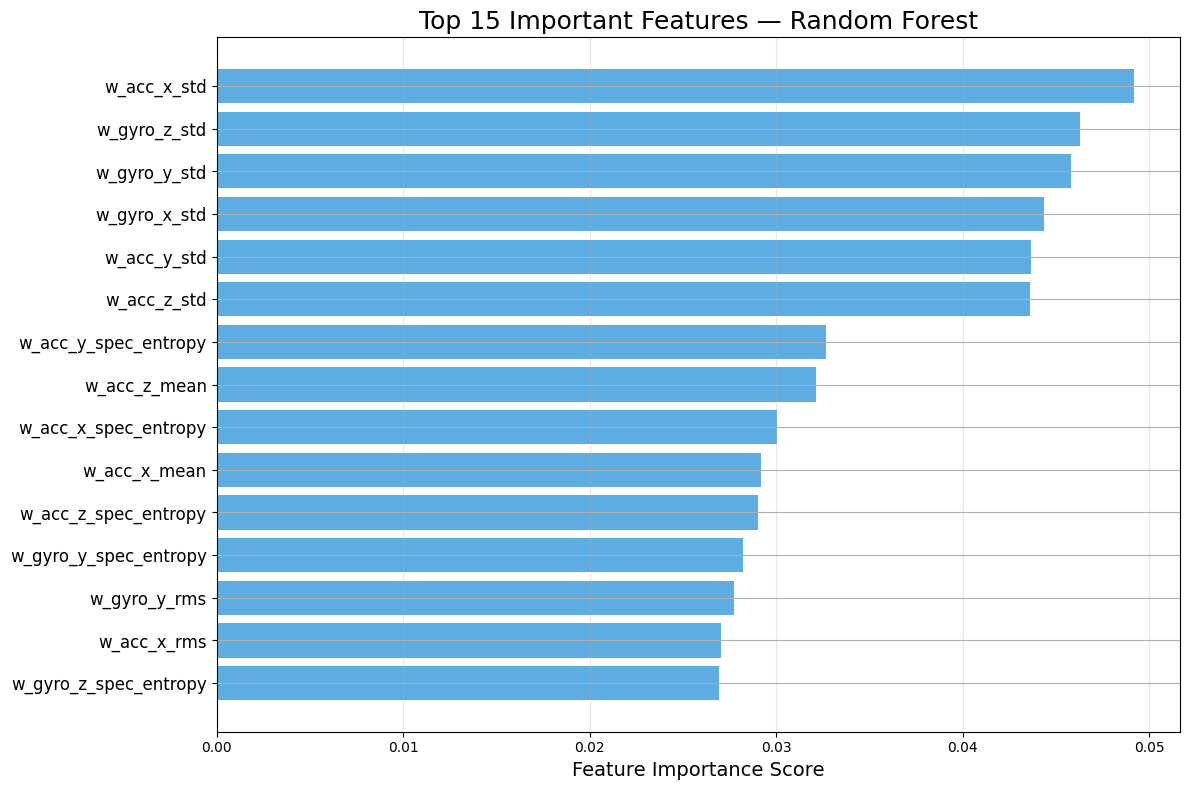

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# --- Get importances and pair with names ---
importances = rf.feature_importances_
feat = list(zip(feature_names, importances))

# --- Sort by importance (descending) ---
feat_sorted = sorted(feat, key=lambda x: x[1], reverse=True)

# --- Select TOP 15 ---
top_k = 15
top_features = feat_sorted[:top_k]

names = [f[0] for f in top_features]
scores = [f[1] for f in top_features]

# --- Horizontal bar chart ---
plt.figure(figsize=(12, 8))
plt.barh(range(top_k), scores, color="#5dade2")
plt.gca().invert_yaxis()   # Most important at the top

plt.yticks(range(top_k), names, fontsize=12)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Top 15 Important Features — Random Forest", fontsize=18)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## **Task 6 — Modeling**

In this task, we implemented and evaluated several **classical machine learning models** and prepared the dataset for **deep learning** experiments.

### **1. Data Cleaning and Preprocessing**
Before training, we identified and removed any **fully missing (NaN) feature columns**.
All infinite values were replaced with NaNs to ensure compatibility with imputers.  
A `SimpleImputer` (median or mean) was included in each model pipeline to handle missing data consistently.

### **2. Model Setup**
We trained and compared six classical machine learning models:

- **Decision Tree**
- **Support Vector Machine (RBF kernel)**
- **Gaussian Naive Bayes**
- **Random Forest**
- **AdaBoost**
- **XGBoost** (installed and added conditionally)

Each model was implemented using `scikit-learn` pipelines that included preprocessing steps such as imputation and standardization (for SVM).  
A **stratified 80/20 train–test split** was applied to maintain class balance across splits.

### **3. Training and Evaluation**
All models were trained on the same data split for fair comparison.  
A shared evaluation function was used to:
- Compute **accuracy**, **macro-F1**, and **weighted-F1** scores  
- Generate detailed **classification reports**  
- Plot **confusion matrices** for each model  

The overall results were compiled into a **leaderboard**, sorted by macro-F1 and accuracy.  
Performance metrics were visualized using bar plots for easier comparison.

### **4. Deep Learning Input Preparation**
To extend the preprocessing pipeline for deep learning:
- Raw sensor **window sequences** (`windows` array of shape *(N, T, C)*) were normalized **per channel** using global mean and standard deviation.  
- Labels were **encoded** (integer + one-hot) for compatibility with neural network frameworks.  
- The data was split into **training (70%)**, **validation (15%)**, and **test (15%)** sets while preserving class balance.  

Metadata such as class names, number of classes, sequence length, and normalization statistics were stored for later use in ANN models.

### **5. Summary**
- Implemented and evaluated six classical machine learning models.  
- Ensured consistent preprocessing (imputation, scaling, encoding).  
- Compared model performances using macro-F1 and accuracy.  
- Prepared normalized sequential data and encoded labels for deep learning.  
- Generated a leaderboard and visualizations to summarize results.  



In [54]:
import numpy as np
import pandas as pd

# Identify fully-missing columns
mask_all_nan = np.all(np.isnan(X), axis=0)
print("Columns fully NaN:", np.where(mask_all_nan)[0])

# Drop them
X = X[:, ~mask_all_nan]
feature_names = np.array(feature_names)[~mask_all_nan]
print("New X shape:", X.shape)


Columns fully NaN: [42 43 44 47 48 49 50 51 54 55 56 57 58 61 62 63 64 65 68 69 70 71 72 75
 76 77 78 79 82 83]
New X shape: (65393, 54)


In [55]:
import importlib, subprocess, sys

try:
    import xgboost
    print("✅ XGBoost already installed:", xgboost.__version__)
except ImportError:
    print("⚙️ Installing XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost
    print("✅ XGBoost installed:", xgboost.__version__)


✅ XGBoost already installed: 3.1.1


(52314, 54) (13079, 54)  | classes: ['F' 'G' 'H' 'I' 'J' 'K' 'L' 'O' 'P' 'Q' 'R' 'S']

Model: DecisionTree
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9248    0.9382    0.9315      1036
           G     0.9458    0.9120    0.9286      1091
           H     0.8582    0.8590    0.8586      1099
           I     0.7966    0.8149    0.8056      1086
           J     0.8236    0.8333    0.8285      1020
           K     0.8473    0.8495    0.8484      1143
           L     0.7661    0.7640    0.7651      1072
           O     0.9482    0.9198    0.9338      1134
           P     0.9320    0.9231    0.9275      1144
           Q     0.9195    0.9238    0.9216      1063
           R     0.9255    0.9306    0.9281      1095
           S     0.9059    0.9224    0.9141      1096

    accuracy                         0.8829     13079
   macro avg     0.8828    0.8826    0.8826     13079


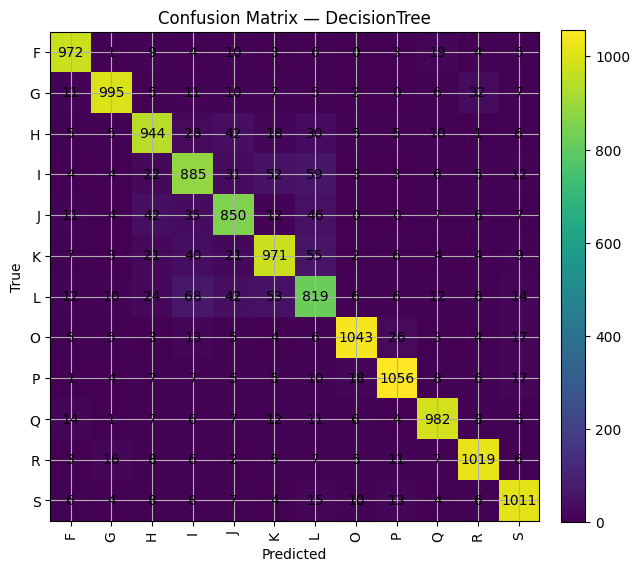


Model: SVM_RBF
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.7219    0.7867    0.7529      1036
           G     0.7988    0.7278    0.7616      1091
           H     0.6550    0.6288    0.6416      1099
           I     0.6569    0.6418    0.6493      1086
           J     0.5818    0.6657    0.6209      1020
           K     0.5442    0.7542    0.6322      1143
           L     0.6755    0.5728    0.6199      1072
           O     0.8769    0.8166    0.8457      1134
           P     0.8923    0.9196    0.9057      1144
           Q     0.8000    0.7865    0.7932      1063
           R     0.8661    0.7205    0.7866      1095
           S     0.8433    0.7609    0.8000      1096

    accuracy                         0.7332     13079
   macro avg     0.7427    0.7318    0.7341     13079
weighted avg     0.7440    0.7332    0.7354     13079



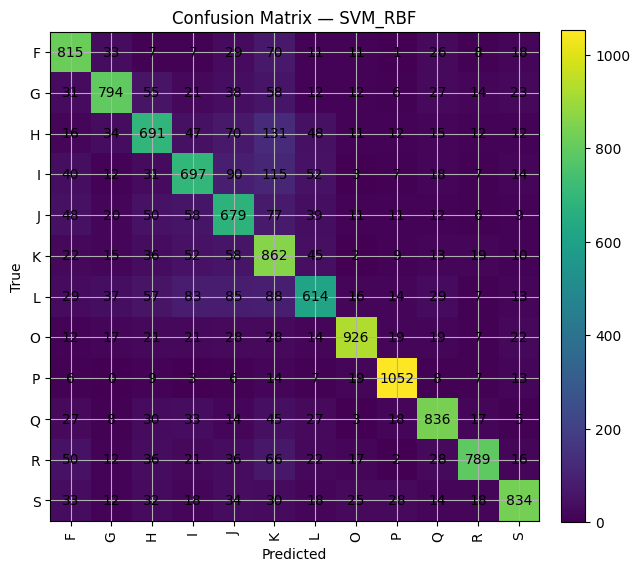


Model: NaiveBayes_Gaussian
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.0811    0.0232    0.0360      1036
           G     0.2008    0.0467    0.0758      1091
           H     0.0812    0.0409    0.0544      1099
           I     0.0312    0.0037    0.0066      1086
           J     0.1279    0.8304    0.2216      1020
           K     0.1143    0.2782    0.1620      1143
           L     0.0139    0.0009    0.0017      1072
           O     0.4066    0.0979    0.1578      1134
           P     0.5255    0.3776    0.4395      1144
           Q     0.1768    0.0329    0.0555      1063
           R     0.3511    0.1680    0.2273      1095
           S     0.2287    0.1150    0.1530      1096

    accuracy                         0.1665     13079
   macro avg     0.1949    0.1680    0.1326     13079
weighted avg     0.1978    0.1665    0.1344     13079



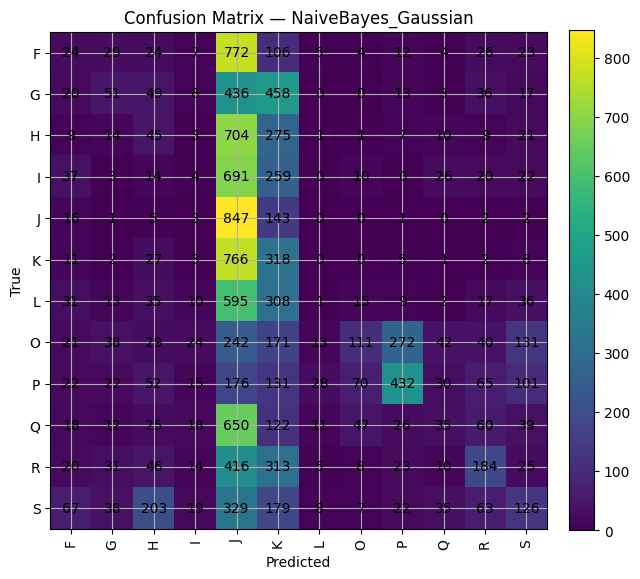


Model: RandomForest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9571    0.9691    0.9631      1036
           G     0.9859    0.9633    0.9745      1091
           H     0.9411    0.9454    0.9433      1099
           I     0.8894    0.9033    0.8963      1086
           J     0.9030    0.9402    0.9212      1020
           K     0.9281    0.9265    0.9273      1143
           L     0.9257    0.8489    0.8856      1072
           O     0.9830    0.9683    0.9756      1134
           P     0.9876    0.9712    0.9793      1144
           Q     0.9554    0.9680    0.9617      1063
           R     0.9780    0.9744    0.9762      1095
           S     0.9259    0.9808    0.9526      1096

    accuracy                         0.9468     13079
   macro avg     0.9467    0.9466    0.9464     13079
weighted avg     0.9471    0.9468    0.9467     13079



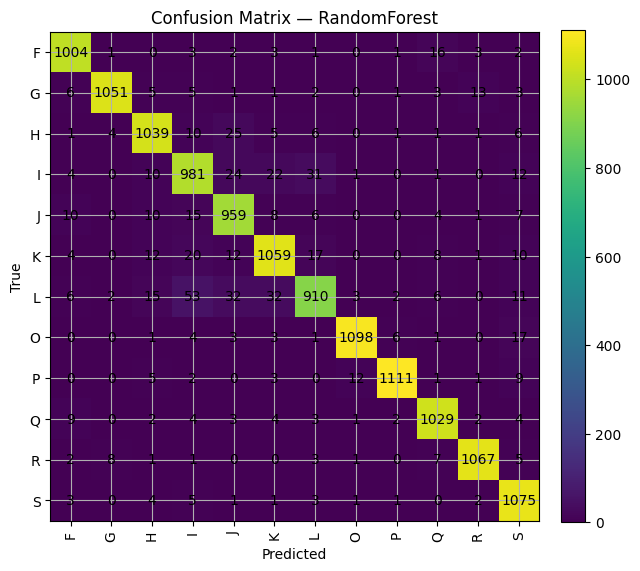


Model: AdaBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.3408    0.3967    0.3666      1036
           G     0.4801    0.2979    0.3676      1091
           H     0.1954    0.2866    0.2324      1099
           I     0.3510    0.2495    0.2917      1086
           J     0.3378    0.2225    0.2683      1020
           K     0.1804    0.4392    0.2557      1143
           L     0.1826    0.0802    0.1115      1072
           O     0.3760    0.1631    0.2276      1134
           P     0.4396    0.4808    0.4593      1144
           Q     0.4553    0.3255    0.3796      1063
           R     0.4743    0.2950    0.3637      1095
           S     0.2673    0.4151    0.3252      1096

    accuracy                         0.3055     13079
   macro avg     0.3401    0.3044    0.3041     13079
weighted avg     0.3399    0.3055    0.3043     13079



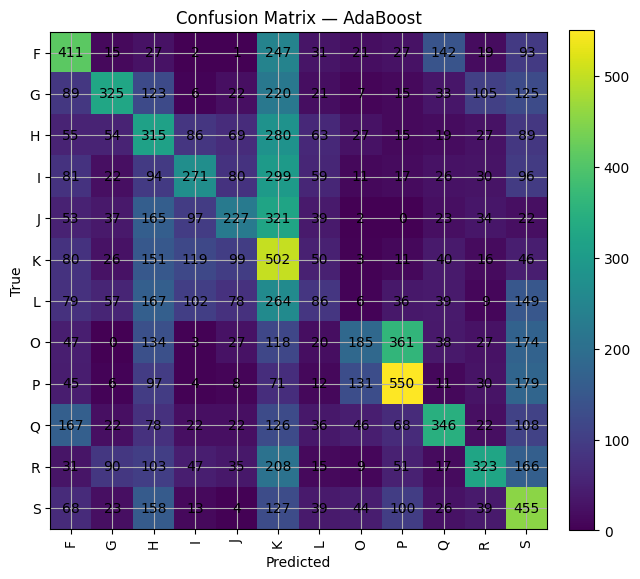


Model: XGBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9683    0.9730    0.9706      1036
           G     0.9812    0.9569    0.9689      1091
           H     0.9343    0.9318    0.9330      1099
           I     0.8653    0.8812    0.8732      1086
           J     0.8884    0.9127    0.9004      1020
           K     0.9057    0.9326    0.9190      1143
           L     0.8924    0.8358    0.8632      1072
           O     0.9768    0.9674    0.9721      1134
           P     0.9850    0.9729    0.9789      1144
           Q     0.9598    0.9652    0.9625      1063
           R     0.9770    0.9717    0.9744      1095
           S     0.9443    0.9754    0.9596      1096

    accuracy                         0.9401     13079
   macro avg     0.9399    0.9397    0.9396     13079
weighted avg     0.9403    0.9401    0.9400     13079



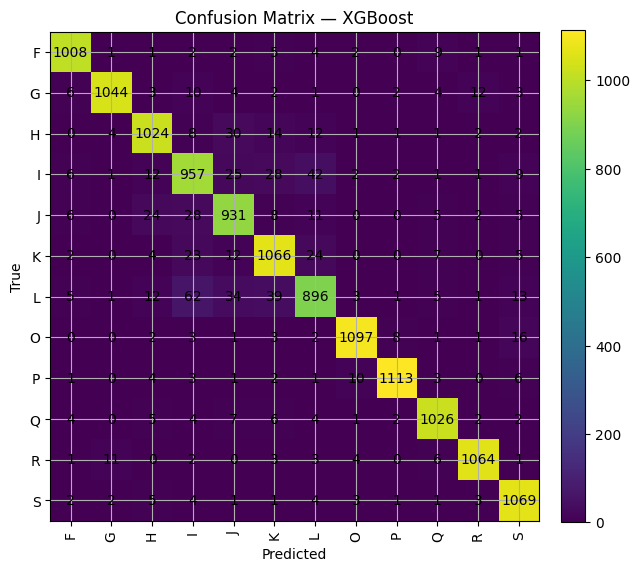

Leaderboard (sorted by F1-macro then Accuracy):
              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.946785  0.946389     0.946693
            XGBoost  0.940057  0.939643     0.940011
       DecisionTree  0.882866  0.882609     0.883039
            SVM_RBF  0.733160  0.734135     0.735384
           AdaBoost  0.305528  0.304109     0.304331
NaiveBayes_Gaussian  0.166526  0.132611     0.134370


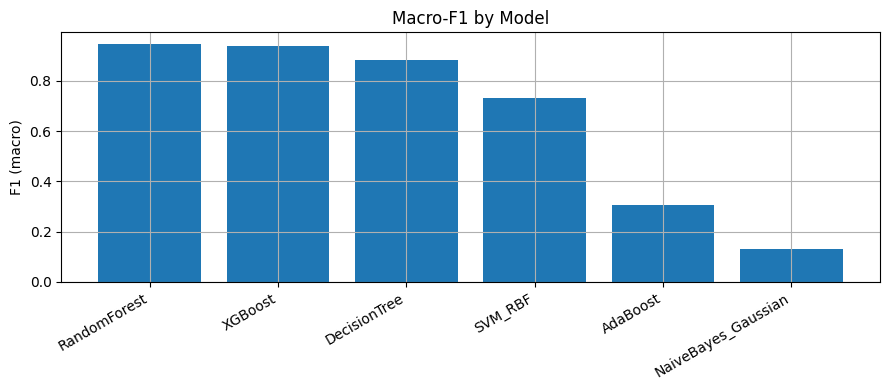

Deep Learning sequence shapes:
  X_train_seq: (45775, 200, 12)  y_train_int: (45775,)
  X_val_seq:   (9809, 200, 12)  y_val_int:   (9809,)
  X_test_seq:  (9809, 200, 12)  y_test_int:  (9809,)


In [56]:

## Task 6 — Classical ML Models + Deep Learning Input Prep (WISDM)
# Run these cells  after feature extraction.

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


# ## 1) Single split shared by all classical models
# Keeps the comparison fair (same train/test across models).


# Encode string labels -> integers 0..C-1
le_global = LabelEncoder()
y_enc = le_global.fit_transform(y)          
class_names = le_global.classes_             
num_classes = len(class_names)

# Single split shared by all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(X_train.shape, X_test.shape, " | classes:", class_names)



# ## 2) Helper — evaluation & reporting
# Prints a classification report, draws a confusion matrix, and returns summary metrics.


def evaluate_model(model, name: str) -> Dict[str, Any]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    print("\n" + "="*80)
    print(f"Model: {name}")
    print("-"*80)
    print(classification_report(
        y_test, y_pred, target_names=class_names, digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    fig, ax = plt.subplots(figsize=(6.5, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "estimator": model,
    }



# ## 3) Define classical models
# - Decision Tree
# - SVM (RBF) with `StandardScaler`
# - Gaussian Naive Bayes
# - Random Forest (balanced)
# - AdaBoost
# - XGBoost (if installed)

# Replace +/- inf with NaN so the imputer can handle them
X = np.where(np.isfinite(X), X, np.nan)

models = [
    ("DecisionTree", make_pipeline(
        SimpleImputer(strategy="median"),
        DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, random_state=42)
    )),

    ("SVM_RBF", make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        SVC(C=10.0, kernel="rbf", gamma="scale", probability=False, random_state=42)
    )),

    ("NaiveBayes_Gaussian", make_pipeline(
        SimpleImputer(strategy="mean"),   
        GaussianNB()
    )),

    ("RandomForest", make_pipeline(
        SimpleImputer(strategy="median"),
        RandomForestClassifier(n_estimators=300, class_weight="balanced",
                               max_features="sqrt", random_state=42, n_jobs=-1)
    )),

    ("AdaBoost", make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.5,
        algorithm="SAMME",   
        random_state=42
        )
    )),

]


# XGBoost can handle NaNs but we keep imputer for consistency
models.append(("XGBoost", make_pipeline(
     SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="multi:softmax", 
        num_class=len(np.unique(y)),  
        random_state=42, n_jobs=-1, tree_method="hist"
    )
)))



# ## 4) Train/evaluate all models + leaderboard
results = []
for name, est in models:
    try:
        res = evaluate_model(est, name)
        results.append(res)
    except Exception as e:
        print(f"[Warning] {name} failed: {e}")

leaderboard = pd.DataFrame(results).sort_values(by=["f1_macro", "accuracy"], ascending=False)
print("Leaderboard (sorted by F1-macro then Accuracy):")
print(leaderboard[["model", "accuracy", "f1_macro", "f1_weighted"]].to_string(index=False))

plt.figure(figsize=(9,4))
plt.bar(leaderboard["model"], leaderboard["f1_macro"])  
plt.title("Macro-F1 by Model")
plt.ylabel("F1 (macro)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# ## 5) Deep Learning input prep (sequences)
# Produces normalized sequences and encoded labels, with train/val/test splits.

# Encode labels to integers 0..C-1
le = LabelEncoder()
labels_int = le.fit_transform(labels)
class_names = list(le.classes_)
num_classes = len(class_names)

# Normalize per-channel over the entire dataset
win = windows.astype(np.float32)           
N, T, C = win.shape
ch_mean = win.reshape(-1, C).mean(axis=0)
ch_std  = win.reshape(-1, C).std(axis=0) + 1e-8
win_norm = (win - ch_mean) / ch_std

# One-hots (for Keras); integers are fine for PyTorch CE loss
enc = OneHotEncoder(sparse_output=False)
Y_onehot = enc.fit_transform(labels_int.reshape(-1,1))

X_train_seq, X_temp_seq, y_train_int, y_temp_int = train_test_split(
    win_norm, labels_int, test_size=0.3, random_state=42, stratify=labels_int
)
X_val_seq, X_test_seq, y_val_int, y_test_int = train_test_split(
    X_temp_seq, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

Y_train_oh = enc.transform(y_train_int.reshape(-1,1))
Y_val_oh   = enc.transform(y_val_int.reshape(-1,1))
Y_test_oh  = enc.transform(y_test_int.reshape(-1,1))

print("Deep Learning sequence shapes:")
print("  X_train_seq:", X_train_seq.shape, " y_train_int:", y_train_int.shape)
print("  X_val_seq:  ", X_val_seq.shape,   " y_val_int:  ", y_val_int.shape)
print("  X_test_seq: ", X_test_seq.shape,  " y_test_int: ", y_test_int.shape)

DL_META = {
    "class_names": class_names,
    "num_classes": num_classes,
    "seq_len": T,
    "num_channels": C,
    "channel_mean": ch_mean,
    "channel_std": ch_std,
}



Leaderboard summary:

              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.946785  0.946389     0.946693
            XGBoost  0.940057  0.939643     0.940011
       DecisionTree  0.882866  0.882609     0.883039
            SVM_RBF  0.733160  0.734135     0.735384
           AdaBoost  0.305528  0.304109     0.304331
NaiveBayes_Gaussian  0.166526  0.132611     0.134370


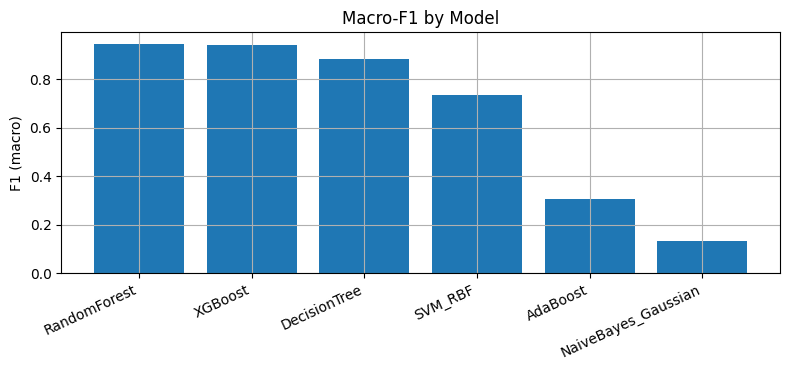

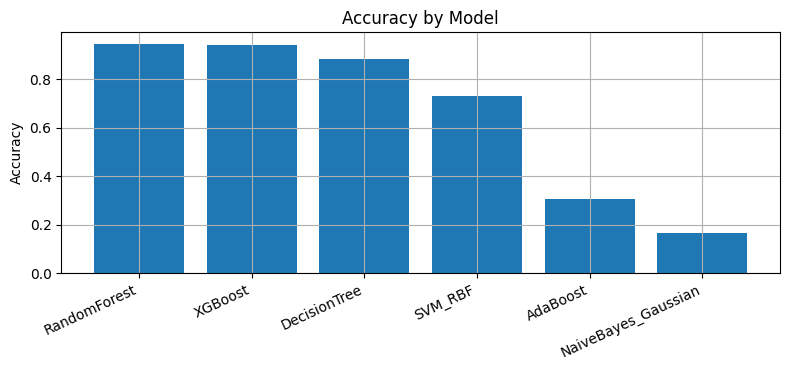

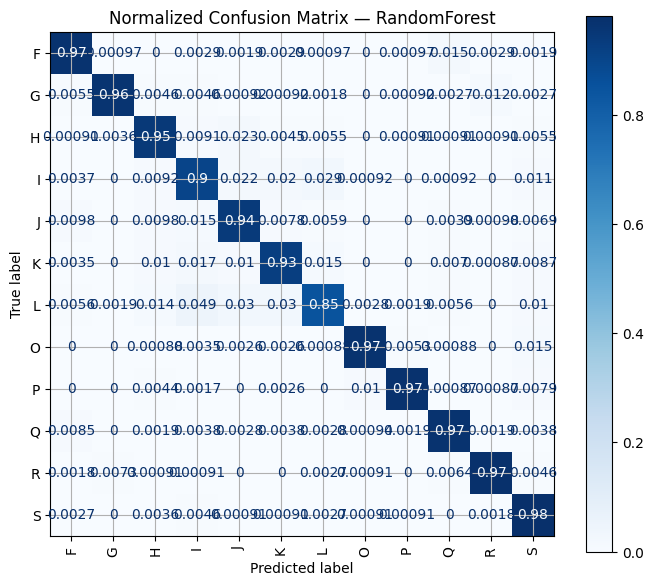

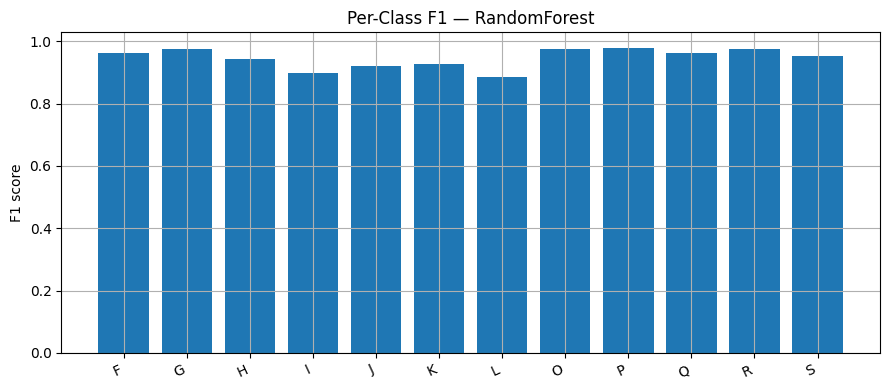

Best Model: RandomForest
Classification report (best model):
              precision    recall  f1-score   support

           F     0.9571    0.9691    0.9631      1036
           G     0.9859    0.9633    0.9745      1091
           H     0.9411    0.9454    0.9433      1099
           I     0.8894    0.9033    0.8963      1086
           J     0.9030    0.9402    0.9212      1020
           K     0.9281    0.9265    0.9273      1143
           L     0.9257    0.8489    0.8856      1072
           O     0.9830    0.9683    0.9756      1134
           P     0.9876    0.9712    0.9793      1144
           Q     0.9554    0.9680    0.9617      1063
           R     0.9780    0.9744    0.9762      1095
           S     0.9259    0.9808    0.9526      1096

    accuracy                         0.9468     13079
   macro avg     0.9467    0.9466    0.9464     13079
weighted avg     0.9471    0.9468    0.9467     13079



In [57]:

# # Task 9 — Report: Results Plots and Model Descriptions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support

# Safety: rebuild a compact results frame if needed
if 'leaderboard' not in globals() or leaderboard is None or leaderboard.empty:
    try:
        leaderboard = pd.DataFrame(results)
    except Exception:
        leaderboard = pd.DataFrame([])

if not leaderboard.empty:
    lb = leaderboard.copy()
    # Keep only public columns, sorted by macro-F1 then accuracy
    keep_cols = [c for c in ["model", "accuracy", "f1_macro", "f1_weighted"] if c in lb.columns]
    lb = lb[keep_cols].sort_values(["f1_macro", "accuracy"], ascending=False)
else:
    lb = pd.DataFrame([])

print("\nLeaderboard summary:\n")
if not lb.empty:
    print(lb.to_string(index=False))
else:
    print("No leaderboard found — run Task 6 first.")

# ## 9.1 Overall Performance Plots
# Bar charts for macro-F1 and accuracy across all classical models.

# %%
if not lb.empty:
    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["f1_macro"])  # default colors only
    plt.title("Macro-F1 by Model")
    plt.ylabel("F1 (macro)")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["accuracy"])  # default colors only
    plt.title("Accuracy by Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()


# ## 9.2 Best Model: Confusion Matrix & Per-Class Scores


if not lb.empty:
    # Find the stored estimator in `results` matching best by f1_macro
    best_name = lb.iloc[0]["model"]
    best_entry = None
    for r in results:
        if r.get("model") == best_name:
            best_entry = r
            break

    if best_entry is not None:
        best_est = best_entry["estimator"]
        # Access the global split from Task 6
        y_pred_best = best_est.predict(X_test)

        # Normalized confusion matrix
        # y_test / y_pred_best are integers 0..num_classes-1 from Task 6 (LabelEncoder)
        cm = confusion_matrix(
            y_test,
            y_pred_best,
            labels=np.arange(num_classes),   # <-- use encoded label indices
            normalize="true"
        )

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=class_names       # <-- readable labels (e.g., ['F','G',...,'S'] or full names)
        )

        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
        ax.set_title(f"Normalized Confusion Matrix — {best_name}")
        plt.tight_layout()
        plt.show()


        # Per-class F1 bar chart
        labels_idx = np.arange(num_classes)  # 0..num_classes-1
        pr, rc, f1, sup = precision_recall_fscore_support(
            y_test, y_pred_best, labels=labels_idx, zero_division=0
        )

# Show codes (['F','G',...]) or map to full names if you have activity_code2name
        class_display = class_names  # or [activity_code2name.get(c, c) for c in class_names]

        plt.figure(figsize=(9, 4))
        plt.bar(range(num_classes), f1)              # numeric positions
        plt.xticks(range(num_classes), class_display, rotation=25, ha='right')
        plt.title(f"Per-Class F1 — {best_name}")
        plt.ylabel("F1 score")
        plt.tight_layout()
        plt.show()

        # Text report (for copy/paste into papers)
        print(f"Best Model: {best_name}")
        print("Classification report (best model):")
        print(classification_report(y_test, y_pred_best, target_names=class_names, digits=4))

    else:
        print("Could not locate the best estimator in `results`. Re-run Task 6.")
else:
    print("Leaderboard empty — run Task 6 first.")
